In [1]:
import pandas as pd
import pickle

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import chi2_contingency
import scipy.stats as stats
from math import log10, log2

def ICD10_code_to_chapter(let):
    if let == 'nan':
        return 'NaN';
    elif let[0] == 'A' or let[0] == 'B':
        return 'A00–B99';
    elif let[0] == 'C' or (let[0] == 'D' and int(let[1])>=0 and int(let[1])<5):
        return 'C00–D48';
    elif let[0] == 'D' and int(let[1])>=5 and int(let[1])<9:
        return 'D50–D89';
    elif let[0] == 'E':
        return 'E00–E90';
    elif let[0] == 'H' and int(let[1])>=0 and int(let[1])<6:
        return 'H00–H59';
    elif let[0] == 'H' and int(let[1])>=6 and int(let[1])<=9:
        return 'H60–H95';
    elif let[0] == 'K':
        return 'K00–K93';
    elif let[0] == 'P':
        return 'P00–P96';
    elif let[0] == 'S' or let[0] == 'T':
        return 'S00–T98';
    elif let[0] in ['V','W','X','Y']:
        return 'V01–Y98';
    elif let[0] in ['F', 'G','I', 'J', 'L', 'M', 'N', 'O','Q','R','Z','U']:
        return '{}00–{}99'.format(let[0], let[0]);
    else:
        return let;
    
def ICDchapter_to_name(chp):
    if chp == 'nan': return 'NaN';
    elif chp == 'A00–B99': return 'Infectious';
    elif chp == 'C00–D48': return 'Neoplasms';
    elif chp == 'D50–D89': return 'Blood-Related Disorders';
    elif chp == 'E00–E90': return 'Endocrine, Nutritional and Metabolic Disorders';
    elif chp == 'F00–F99': return 'Mental and Behavioural Disorders';
    elif chp == 'G00–G99': return 'Diseases of Nervous System';
    elif chp == 'H00–H59': return 'Diseases of Eye and Adnexa';
    elif chp == 'H60–H95': return 'Diseases of Ear and Mastoid process';
    elif chp == 'I00–I99': return 'Diseases of Circulatory System';
    elif chp == 'J00–J99': return 'Diseases of Respiratory System';
    elif chp == 'K00–K93': return 'Diseases of Digestive System';
    elif chp == 'L00–L99': return 'Diseases of Skin and Subcutaneous Tissue';
    elif chp == 'M00–M99': return 'Musculoskeletal System Diseases';
    elif chp == 'N00–N99': return 'Genitourinary System Diseases';
    elif chp == 'O00–O99': return 'Pregnancy and Childbirth';
    elif chp == 'P00–P96': return 'Perinatal Diseases';
    elif chp == 'Q00–Q99': return 'Congenital Diseases';
    elif chp == 'R00–R99': return 'Abnormal Clinical and Lab Findings';
    elif chp == 'S00–T98': return 'Injury, Poisoning and External Issues';
    elif chp == 'V01–Y98': return 'External Causes';
    elif chp == 'Z00–Z99': return 'Health Status and Services';
    elif chp == 'U00–U99': return 'Codes for special purposes';
    else: return ' ';

In [3]:
positive = pd.read_csv('upset_df_AD_diagnosis_ICDfull_positive.csv')

In [4]:
positive['sum'] = positive[['c0', 'c1', 'c2', 'c3', 'c4']].sum(axis=1)

In [5]:
positive = positive[positive['sum']==1]

In [6]:
negative = pd.read_csv('upset_df_AD_diagnosis_ICDfull_negative_revised.csv')

In [7]:
negative['sum'] = negative[['c0', 'c3', 'c4']].sum(axis=1)

In [8]:
negative = negative[negative['sum']==1]

In [9]:
specific_icd = pd.concat([positive, negative], axis=0, ignore_index=True)

In [10]:
# c0-c4列をobject型に変換
columns_to_convert = ['c0', 'c1', 'c2', 'c3', 'c4']
specific_icd[columns_to_convert] = specific_icd[columns_to_convert].astype(str)

In [11]:
# ファイル名とデータを格納する辞書を用意
data_dict = {}

# c0からc4までのファイルをループで読み込み、Cluster列を追加
for i in range(5):
    file_name = f'c{i}_label_positions_AD_ICD10_volcano.csv'  # ファイル形式をCSVに変更
    try:
        # CSVファイルを読み込む
        df = pd.read_csv(file_name)
        
        # Cluster列を追加して値を設定
        df['Cluster'] = i
        
        # 辞書にデータフレームを保存
        data_dict[f'c{i}'] = df
    except FileNotFoundError:
        print(f"File not found: {file_name}")
    except pd.errors.EmptyDataError:
        print(f"Empty file or no data: {file_name}")
    except Exception as e:
        print(f"An error occurred while processing {file_name}: {e}")

In [12]:
# 辞書内のデータフレームをすべて縦に結合
combined_df = pd.concat(data_dict.values(), ignore_index=False)

In [13]:
combined_df

,Label,X,Y,ICD10_chape,flag,mapping,Cluster
0,I10,-3.501890,311.141798,['I00–I99'],0.0,Essential (primary) hypertension,0
1,F02.80,-0.580468,17.283751,['F00–F99'],1.0,Dementia in other diseases classified elsewhere,0
2,F03.90,-2.259136,241.876775,['F00–F99'],0.0,Unspecified dementia,0
3,R41.3,-1.255849,67.037987,['R00–R99'],0.0,NaN,0
4,E78.5,-2.636000,300.520953,['E00–E90'],0.0,Disorders of lipoprotein metabolism and other ...,0
...,...,...,...,...,...,...,...
250,J96.91,-11.000000,6.705626,['J00–J99'],0.0,NaN,4
251,E78.0,-11.000000,5.949429,['E00–E90'],0.0,Disorders of lipoprotein metabolism and other ...,4
252,R06.83,-11.000000,5.754022,['R00–R99'],0.0,NaN,4
253,Z82.3,-11.000000,5.526201,['Z00–Z99'],0.0,NaN,4


In [14]:
specific_data = combined_df

In [15]:
# 'IMO' を含むレコードを削除
specific_data = specific_data[~specific_data['Label'].str.contains('IMO', na=False)]

In [16]:
# ICD-10コード順に並べ替え
specific_data = specific_data.sort_values(by='ICD10_chape')

In [17]:
specific_data['ICD10_chape'] = specific_data['ICD10_chape'].str.strip("[]'")

# Count the number of ICD in each cluster

In [18]:
# ファイル名とデータを格納する辞書を用意
data_dict = {}

# c0からc4までのファイルをループで読み込み、Cluster列を追加
for i in range(5):
    file_name = f'all_diagnosis_stats_c{i}_other_AD.pickle'
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
        df = pd.DataFrame(data['ICD10'])  # データをデータフレームに変換
        df['Cluster'] = i  # Cluster列を追加して値を設定
        data_dict[f'c{i}'] = df  # 辞書に保存

In [19]:
# 辞書内のデータフレームをすべて縦に結合
combined_df = pd.concat(data_dict.values(), ignore_index=False)

In [20]:
all_data = combined_df[['-log_pvalue','pvalue','OddsRatio','Cluster']]

In [21]:
all_data = all_data.reset_index()

In [22]:
all_data['ICD10_chape'] = all_data['ICD10'].apply(lambda x: ICD10_code_to_chapter(str(x)[0:3])) # Get ICD10 Chapte

In [23]:
all_data['ICD10_chape_name'] = all_data['ICD10_chape'].apply(lambda x: ICDchapter_to_name(x))

In [24]:
# 'IMO' を含むレコードを削除
all_data = all_data[~all_data['ICD10'].str.contains('IMO', na=False)]

In [25]:
c0 = all_data[all_data['Cluster']==0]
c1 = all_data[all_data['Cluster']==1]
c2 = all_data[all_data['Cluster']==2]
c3 = all_data[all_data['Cluster']==3]
c4 = all_data[all_data['Cluster']==4]

In [26]:
all_data

,ICD10,-log_pvalue,pvalue,OddsRatio,Cluster,ICD10_chape,ICD10_chape_name
0,I10,311.141798,7.214422e-312,0.088273,0,I00–I99,Diseases of Circulatory System
1,F02.80,17.283751,5.202943e-18,0.668747,0,F00–F99,Mental and Behavioural Disorders
2,F03.90,241.876775,1.328083e-242,0.208897,0,F00–F99,Mental and Behavioural Disorders
3,R41.3,67.037987,9.162488e-68,0.418747,0,R00–R99,Abnormal Clinical and Lab Findings
4,E78.5,300.520953,3.013335e-301,0.160874,0,E00–E90,"Endocrine, Nutritional and Metabolic Disorders"
...,...,...,...,...,...,...,...
52245,D22.4,-0.000000,1.000000e+00,0.000000,4,C00–D48,Neoplasms
52246,H21.539,-0.000000,1.000000e+00,0.000000,4,H00–H59,Diseases of Eye and Adnexa
52247,S60.419A,-0.000000,1.000000e+00,0.000000,4,S00–T98,"Injury, Poisoning and External Issues"
52248,H70.92,-0.000000,1.000000e+00,0.000000,4,H60–H95,Diseases of Ear and Mastoid process


In [27]:
specific_data

,Label,X,Y,ICD10_chape,flag,mapping,Cluster
726,B19.10,2.100040,6.456436,A00–B99,0.0,Unspecified viral hepatitis,2
603,B95.61,3.742268,9.867628,A00–B99,0.0,NaN,3
433,B96.89,-3.294969,36.343759,A00–B99,0.0,NaN,0
393,B35.3,2.735476,31.832319,A00–B99,NaN,NaN,1
590,A41.89,3.549432,9.145476,A00–B99,0.0,NaN,3
...,...,...,...,...,...,...,...
1096,Z96.651,3.663986,17.403013,Z00–Z99,NaN,NaN,1
203,Z87.01,1.707631,14.456021,Z00–Z99,0.0,NaN,3
1089,Z74.2,3.322982,15.426138,Z00–Z99,NaN,NaN,1
1129,Z92.89,2.359988,7.058277,Z00–Z99,NaN,NaN,1


In [28]:
ORs = all_data[all_data['ICD10'].isin(specific_data['Label'])]

In [29]:
# ピボットテーブルを作成
pivot_df = ORs.pivot_table(index='ICD10',columns='Cluster', values='OddsRatio')

In [30]:
pivot_df.columns = [f'Cluster {int(col)}' for col in pivot_df.columns]

In [31]:
pivot_df = pivot_df.reset_index()

In [32]:
pivot_df

,ICD10,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,A04.7,0.044131,6.171538,2.242250,14.035980,0.000000
1,A04.72,0.166408,1.585698,3.108510,2.458968,2.404492
2,A04.8,0.070320,10.208995,6.568610,1.181841,1.196806
3,A08.4,0.000000,29.181205,1.212446,5.817901,0.000000
4,A08.8,0.061497,6.717350,8.478001,0.288544,1.962133
...,...,...,...,...,...,...
2383,Z99.11,0.067671,5.776330,1.624189,9.632051,0.578215
2384,Z99.2,0.205576,11.453688,1.507444,3.653307,0.298969
2385,Z99.3,0.156273,6.202589,2.112970,4.788997,0.772588
2386,Z99.81,0.168827,6.236919,2.664135,3.460378,0.969574


In [33]:
pivot_df['ICD_chape'] = pivot_df['ICD10'].apply(lambda x: ICD10_code_to_chapter(str(x)[0:3]))

In [34]:
# 絶対値が最も大きいクラスターの番号を取得
pivot_df["Specific Cluster"] = pivot_df[["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]].abs().idxmax(axis=1)

# クラスター番号に "Cluster " を追加
pivot_df["Specific Cluster"] = pivot_df["Specific Cluster"].apply(lambda x: f"{x}")

# 最大値を新しいカラム maxOR に追加
pivot_df["maxOR"] = pivot_df[["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]].abs().max(axis=1)



In [35]:
pivot_df

,ICD10,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,ICD_chape,Specific Cluster,maxOR
0,A04.7,0.044131,6.171538,2.242250,14.035980,0.000000,A00–B99,Cluster 3,14.035980
1,A04.72,0.166408,1.585698,3.108510,2.458968,2.404492,A00–B99,Cluster 2,3.108510
2,A04.8,0.070320,10.208995,6.568610,1.181841,1.196806,A00–B99,Cluster 1,10.208995
3,A08.4,0.000000,29.181205,1.212446,5.817901,0.000000,A00–B99,Cluster 1,29.181205
4,A08.8,0.061497,6.717350,8.478001,0.288544,1.962133,A00–B99,Cluster 2,8.478001
...,...,...,...,...,...,...,...,...,...
2383,Z99.11,0.067671,5.776330,1.624189,9.632051,0.578215,Z00–Z99,Cluster 3,9.632051
2384,Z99.2,0.205576,11.453688,1.507444,3.653307,0.298969,Z00–Z99,Cluster 1,11.453688
2385,Z99.3,0.156273,6.202589,2.112970,4.788997,0.772588,Z00–Z99,Cluster 1,6.202589
2386,Z99.81,0.168827,6.236919,2.664135,3.460378,0.969574,Z00–Z99,Cluster 1,6.236919


# Standardization

In [36]:
from sklearn.preprocessing import StandardScaler

In [37]:
pivot_df.iloc[:, 1:6]

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,0.044131,6.171538,2.242250,14.035980,0.000000
1,0.166408,1.585698,3.108510,2.458968,2.404492
2,0.070320,10.208995,6.568610,1.181841,1.196806
3,0.000000,29.181205,1.212446,5.817901,0.000000
4,0.061497,6.717350,8.478001,0.288544,1.962133
...,...,...,...,...,...
2383,0.067671,5.776330,1.624189,9.632051,0.578215
2384,0.205576,11.453688,1.507444,3.653307,0.298969
2385,0.156273,6.202589,2.112970,4.788997,0.772588
2386,0.168827,6.236919,2.664135,3.460378,0.969574


In [38]:
# OR値の部分を標準化
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df.iloc[:, 1:6])

# 結果をデータフレームに変換
standardized_df = pd.DataFrame(scaled_data,columns=pivot_df.columns[1:6])

In [39]:
standardized_df

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,-0.270277,-0.350786,-0.474266,2.317228,-0.874439
1,0.145112,-0.533187,-0.271068,-0.194347,1.252604
2,-0.181308,-0.190196,0.540563,-0.471413,0.184270
3,-0.420194,0.564422,-0.715826,0.534357,-0.874439
4,-0.211283,-0.329076,0.988447,-0.665209,0.861288
...,...,...,...,...,...
2383,-0.190307,-0.366505,-0.619244,1.361817,-0.362943
2384,0.278171,-0.140689,-0.646628,0.064759,-0.609968
2385,0.110682,-0.349551,-0.504591,0.311141,-0.190998
2386,0.153330,-0.348185,-0.375305,0.022904,-0.016742


In [40]:
umap_df = pd.concat([pivot_df[['ICD10','ICD_chape','Specific Cluster','maxOR']],standardized_df], axis=1)

In [41]:
umap_df

,ICD10,ICD_chape,Specific Cluster,maxOR,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,A04.7,A00–B99,Cluster 3,14.035980,-0.270277,-0.350786,-0.474266,2.317228,-0.874439
1,A04.72,A00–B99,Cluster 2,3.108510,0.145112,-0.533187,-0.271068,-0.194347,1.252604
2,A04.8,A00–B99,Cluster 1,10.208995,-0.181308,-0.190196,0.540563,-0.471413,0.184270
3,A08.4,A00–B99,Cluster 1,29.181205,-0.420194,0.564422,-0.715826,0.534357,-0.874439
4,A08.8,A00–B99,Cluster 2,8.478001,-0.211283,-0.329076,0.988447,-0.665209,0.861288
...,...,...,...,...,...,...,...,...,...
2383,Z99.11,Z00–Z99,Cluster 3,9.632051,-0.190307,-0.366505,-0.619244,1.361817,-0.362943
2384,Z99.2,Z00–Z99,Cluster 1,11.453688,0.278171,-0.140689,-0.646628,0.064759,-0.609968
2385,Z99.3,Z00–Z99,Cluster 1,6.202589,0.110682,-0.349551,-0.504591,0.311141,-0.190998
2386,Z99.81,Z00–Z99,Cluster 1,6.236919,0.153330,-0.348185,-0.375305,0.022904,-0.016742


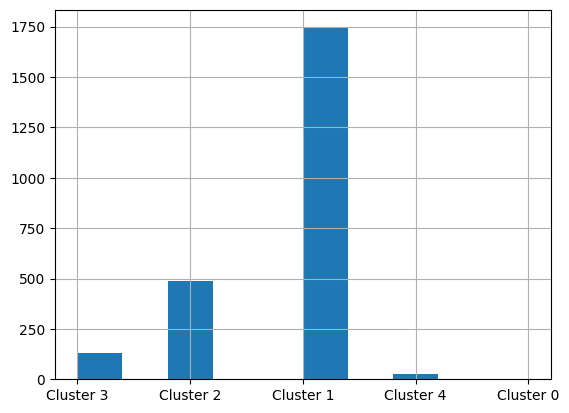

In [42]:
umap_df['Specific Cluster'].hist()
plt.show()

In [43]:
umap_df['Specific Cluster'].describe()

count          2388
unique            5
top       Cluster 1
freq           1747
Name: Specific Cluster, dtype: object

# UMAP

In [44]:
import umap

In [45]:
umap_df.iloc[:, 4:]

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,-0.270277,-0.350786,-0.474266,2.317228,-0.874439
1,0.145112,-0.533187,-0.271068,-0.194347,1.252604
2,-0.181308,-0.190196,0.540563,-0.471413,0.184270
3,-0.420194,0.564422,-0.715826,0.534357,-0.874439
4,-0.211283,-0.329076,0.988447,-0.665209,0.861288
...,...,...,...,...,...
2383,-0.190307,-0.366505,-0.619244,1.361817,-0.362943
2384,0.278171,-0.140689,-0.646628,0.064759,-0.609968
2385,0.110682,-0.349551,-0.504591,0.311141,-0.190998
2386,0.153330,-0.348185,-0.375305,0.022904,-0.016742


In [46]:
X = umap_df.iloc[:, 4:]

In [47]:
y = umap_df['ICD_chape']

In [48]:
#umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
#reduced_data = umap_reducer.fit_transform(X)

In [49]:
umap_reducer = umap.UMAP(n_neighbors=10, min_dist=0.5, random_state=42)
reduced_data = umap_reducer.fit_transform(X)

/wynton/protected/home/sirota/ykatsuhara/.local/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
umap_df.columns[1:]

Index(['ICD_chape', 'Specific Cluster', 'maxOR', 'Cluster 0', 'Cluster 1',
       'Cluster 2', 'Cluster 3', 'Cluster 4'],
      dtype='object')

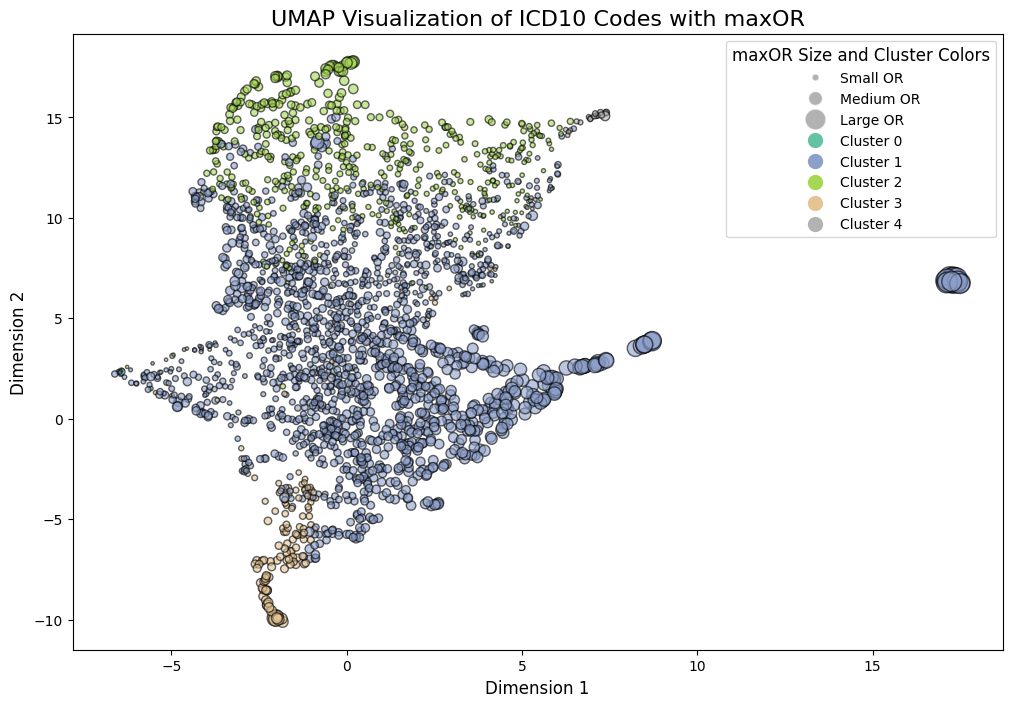

In [52]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

# Set2カラーパレットの最初の5色を取得
set2_colors = cm.get_cmap('Set2', 5).colors
category_color_mapping = {
    'Cluster 0': set2_colors[0],  # Set2の最初の色
    'Cluster 1': set2_colors[1],  # Set2の2番目の色
    'Cluster 2': set2_colors[2],  # Set2の3番目の色
    'Cluster 3': set2_colors[3],  # Set2の4番目の色
    'Cluster 4': set2_colors[4],  # Set2の5番目の色
}

# プロット順序をランダム化
np.random.seed(42)
reordered_indices = np.arange(reduced_data.shape[0])
np.random.shuffle(reordered_indices)

# カラーマッピング
colors = [category_color_mapping.get(icd, '#000000') for icd in umap_df["Specific Cluster"]]

# 対数変換 + 平滑化 + スケーリング
scaled_dot_sizes = (np.log1p(umap_df["maxOR"].values) ** 3.0)  # 対数変換と強調を組み合わせ
scaled_dot_sizes = (scaled_dot_sizes - scaled_dot_sizes.min()) / (scaled_dot_sizes.max() - scaled_dot_sizes.min()) * 200
scaled_dot_sizes += 5  # 最小サイズを確保

# プロット
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    reduced_data[reordered_indices, 0],
    reduced_data[reordered_indices, 1],
    c=np.array(colors)[reordered_indices],  # 各ICD10に対応する色を指定
    s=scaled_dot_sizes[reordered_indices],  # ドットサイズをmaxORに基づいて設定
    alpha=0.6,
    edgecolor='k'  # 境界線を黒に設定
)

# サイズ凡例の作成
size_legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Small OR', markersize=5, markerfacecolor='gray', alpha=0.6),
    plt.Line2D([0], [0], marker='o', color='w', label='Medium OR', markersize=10, markerfacecolor='gray', alpha=0.6),
    plt.Line2D([0], [0], marker='o', color='w', label='Large OR', markersize=15, markerfacecolor='gray', alpha=0.6),
]

# 色凡例の作成
color_legend_elements = [
    plt.Line2D([0], [0], marker='o', color=color, label=cluster, markersize=10, linestyle='None')
    for cluster, color in category_color_mapping.items()
]

# 凡例を追加
plt.legend(
    handles=size_legend_elements + color_legend_elements,
    title="maxOR Size and Cluster Colors",
    fontsize=10,
    loc='upper right',
    title_fontsize=12
)

# グラフの設定
plt.title("UMAP Visualization of ICD10 Codes with maxOR", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.show()


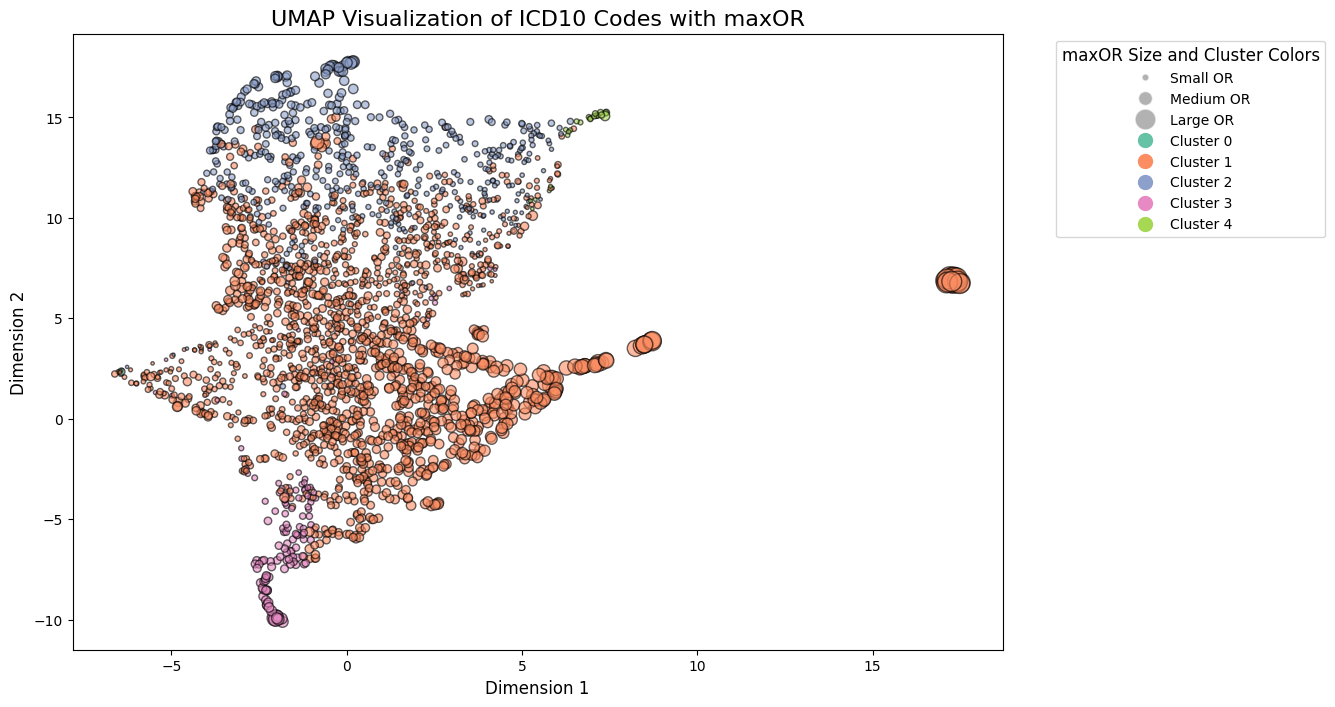

In [53]:
category_color_mapping = {
    'Cluster 0': '#66c2a5',  # 明るいオレンジレッド
    'Cluster 1': '#fc8d62',  # ダークレッド
    'Cluster 2': '#8da0cb',  # 青 - 明るめで視認性高い
    'Cluster 3': '#e78ac3',  # 緑 - 落ち着いた鮮やかさ
    'Cluster 4': '#a6d854',  # 黄 - 明るく視認性の高い色
}
# プロット順序をランダム化
np.random.seed(42)
reordered_indices = np.arange(reduced_data.shape[0])
np.random.shuffle(reordered_indices)

# カラーマッピング
colors = [category_color_mapping.get(icd, '#000000') for icd in umap_df["Specific Cluster"]]

# 対数変換 + 平滑化 + スケーリング
scaled_dot_sizes = (np.log1p(umap_df["maxOR"].values) ** 3.0)  # 対数変換と強調を組み合わせ
scaled_dot_sizes = (scaled_dot_sizes - scaled_dot_sizes.min()) / (scaled_dot_sizes.max() - scaled_dot_sizes.min()) * 200
scaled_dot_sizes += 5  # 最小サイズを確保

# プロット
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    reduced_data[reordered_indices, 0],
    reduced_data[reordered_indices, 1],
    c=np.array(colors)[reordered_indices],  # 各ICD10に対応する色を指定
    s=scaled_dot_sizes[reordered_indices],  # ドットサイズをmaxORに基づいて設定
    alpha=0.6,
    edgecolor='k'  # 境界線を黒に設定
)

# サイズ凡例の作成
size_legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Small OR', markersize=5, markerfacecolor='gray', alpha=0.6),
    plt.Line2D([0], [0], marker='o', color='w', label='Medium OR', markersize=10, markerfacecolor='gray', alpha=0.6),
    plt.Line2D([0], [0], marker='o', color='w', label='Large OR', markersize=15, markerfacecolor='gray', alpha=0.6),
]

# 色凡例の作成
color_legend_elements = [
    plt.Line2D([0], [0], marker='o', color=color, label=cluster, markersize=10, linestyle='None')
    for cluster, color in category_color_mapping.items()
]

# 凡例を追加
plt.legend(
    handles=size_legend_elements + color_legend_elements,
    title="maxOR Size and Cluster Colors",
    fontsize=10,
    loc='upper left',  # 凡例の基準位置（左上を基準）
    bbox_to_anchor=(1.05, 1),  # プロット枠外に配置 (右上)
    title_fontsize=12
)

# グラフの設定
plt.title("UMAP Visualization of ICD10 Codes with maxOR", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.show()


In [54]:
reduced_data

array([[-1.7089543, -6.6598487],
       [ 4.8229194,  9.630534 ],
       [-1.498114 ,  9.768498 ],
       ...,
       [-0.8203944,  2.265786 ],
       [-0.2703005,  4.2542763],
       [-5.0761013,  1.7718649]], dtype=float32)

In [55]:
reduced_df = pd.DataFrame(reduced_data, columns=['X','Y'])

In [56]:
df = pd.concat([pivot_df[['ICD10','ICD_chape','Specific Cluster','maxOR']],reduced_df], axis=1)

In [57]:
df.to_csv('UMAP_OR.csv', index=False)

In [95]:
df[df['Specific Cluster']=='Cluster 0'].sort_values('maxOR')

,ICD10,ICD_chape,Specific Cluster,maxOR,X,Y
370,G31.01,G00–G99,Cluster 0,13.388002,-6.424882,2.343242


In [62]:
df.sort_values('X').tail(30)

,ICD10,ICD_chape,Specific Cluster,maxOR,X,Y
987,K11.1,K00–K93,Cluster 1,124.365325,6.336837,3.233763
601,H52.202,H00–H59,Cluster 1,126.305031,6.338549,3.234220
1493,M85.9,M00–M99,Cluster 1,149.701863,6.347006,3.234632
224,E11.329,E00–E90,Cluster 1,149.701863,6.347531,3.234601
225,E11.3293,E00–E90,Cluster 1,126.305031,6.353426,3.249660
2110,Y83.0,V01–Y98,Cluster 1,175.196262,6.364217,3.236298
993,K12.30,K00–K93,Cluster 1,226.664577,16.309631,5.172351
462,H02.59,H00–H59,Cluster 1,227.664577,16.328747,5.153365
2116,Y92.008,V01–Y98,Cluster 1,227.664577,16.346012,5.135824
1906,S12.300A,S00–T98,Cluster 1,227.664577,16.348860,5.133174


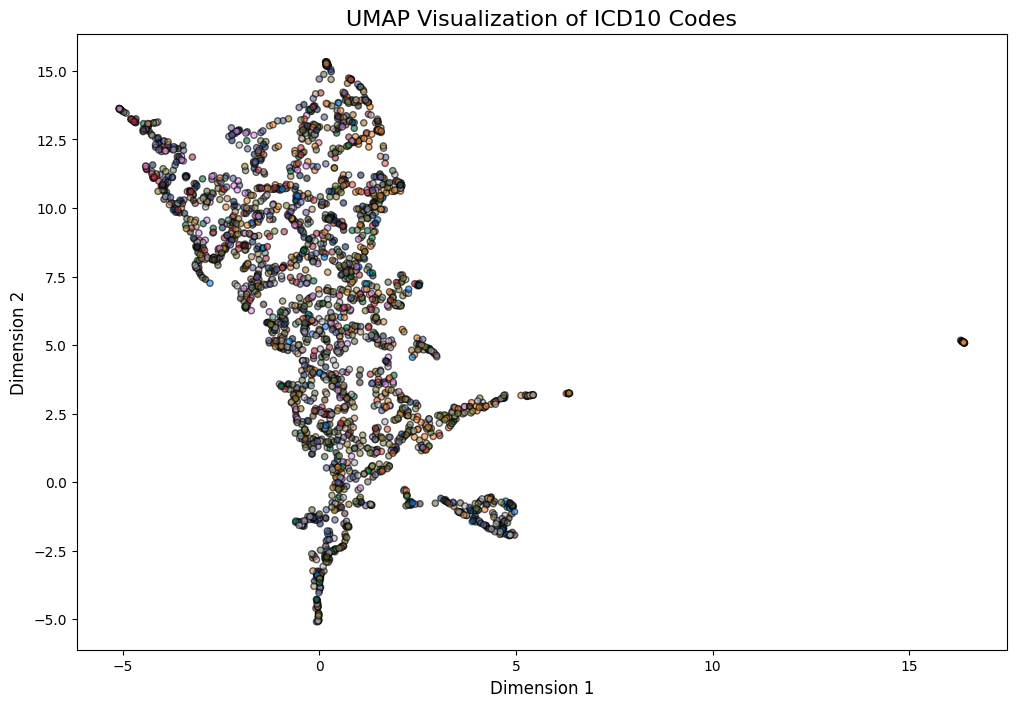

In [192]:
# カラーマッピング辞書（すでに定義済み）
category_color_mapping = {
    'A00–B99': '#a7414a',
    'C00–D48': '#282726',
    'D50–D89': '#6a8a82',
    'E00–E90': '#a37c27',
    'F00–F99': '#563838',
    'G00–G99': '#0584f2',
    'H00–H59': '#f28a30',
    'H60–H95': '#f05837',
    'I00–I99': '#6465a5',
    'J00–J99': '#00743f',
    'K00–K93': '#be9063',
    'L00–L99': '#de8cf0',
    'M00–M99': '#888c46',
    'N00–N99': '#c0334d',
    'O00–O99': '#270101',
    'P00–P96': '#8d2f23',
    'Q00–Q99': '#ee6c81',
    'R00–R99': '#65734b',
    'S00–T98': '#14325c',
    'V01–Y98': '#704307',
    'Z00–Z99': '#b5b3be',
    'U00–U99': '#f67280'
}

# プロット順序をランダム化
np.random.seed(42)
reordered_indices = np.arange(reduced_data.shape[0])
np.random.shuffle(reordered_indices)

# カラーマッピング
colors = [category_color_mapping.get(icd, '#000000') for icd in umap_df["ICD_chape"]]

# プロット
plt.figure(figsize=(12, 8))
plt.scatter(
    reduced_data[reordered_indices, 0],
    reduced_data[reordered_indices, 1],
    c=np.array(colors)[reordered_indices],  # 各ICD10に対応する色を指定
    s=20,
    alpha=0.6,
    edgecolor='k'  # 境界線を黒に設定
)

# グラフの設定
plt.title("UMAP Visualization of ICD10 Codes", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.show()


In [123]:
from sklearn.manifold import TSNE

In [124]:
# t-SNEの場合
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(X)

/wynton/protected/home/sirota/ykatsuhara/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/wynton/protected/home/sirota/ykatsuhara/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


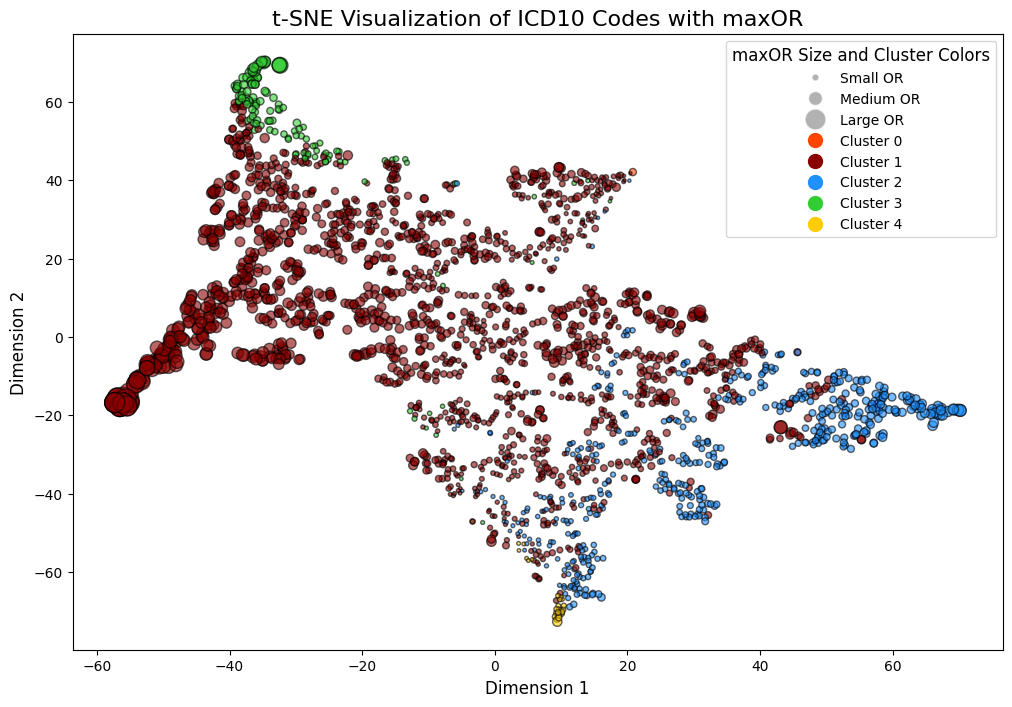

In [134]:
category_color_mapping = {
    'Cluster 0': '#FF4500',  # 明るいオレンジレッド
    'Cluster 1': '#8B0000',  # ダークレッド
    'Cluster 2': '#1e90ff',  # 青 - 明るめで視認性高い
    'Cluster 3': '#32cd32',  # 緑 - 落ち着いた鮮やかさ
    'Cluster 4': '#ffcc00',  # 黄 - 明るく視認性の高い色
}
# プロット順序をランダム化
np.random.seed(42)
reordered_indices = np.arange(reduced_data.shape[0])
np.random.shuffle(reordered_indices)

# カラーマッピング
colors = [category_color_mapping.get(icd, '#000000') for icd in umap_df["Specific Cluster"]]

# 対数変換 + 平滑化 + スケーリング
scaled_dot_sizes = (np.log1p(umap_df["maxOR"].values) ** 3.0)  # 対数変換と強調を組み合わせ
scaled_dot_sizes = (scaled_dot_sizes - scaled_dot_sizes.min()) / (scaled_dot_sizes.max() - scaled_dot_sizes.min()) * 200
scaled_dot_sizes += 5  # 最小サイズを確保

# プロット
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    reduced_data[reordered_indices, 0],
    reduced_data[reordered_indices, 1],
    c=np.array(colors)[reordered_indices],  # 各ICD10に対応する色を指定
    s=scaled_dot_sizes[reordered_indices],  # ドットサイズをmaxORに基づいて設定
    alpha=0.6,
    edgecolor='k'  # 境界線を黒に設定
)

# サイズ凡例の作成
size_legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Small OR', markersize=5, markerfacecolor='gray', alpha=0.6),
    plt.Line2D([0], [0], marker='o', color='w', label='Medium OR', markersize=10, markerfacecolor='gray', alpha=0.6),
    plt.Line2D([0], [0], marker='o', color='w', label='Large OR', markersize=15, markerfacecolor='gray', alpha=0.6),
]

# 色凡例の作成
color_legend_elements = [
    plt.Line2D([0], [0], marker='o', color=color, label=cluster, markersize=10, linestyle='None')
    for cluster, color in category_color_mapping.items()
]

# 凡例を追加
plt.legend(
    handles=size_legend_elements + color_legend_elements,
    title="maxOR Size and Cluster Colors",
    fontsize=10,
    loc='upper right',
    title_fontsize=12
)

# グラフの設定
plt.title("t-SNE Visualization of ICD10 Codes with maxOR", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.show()


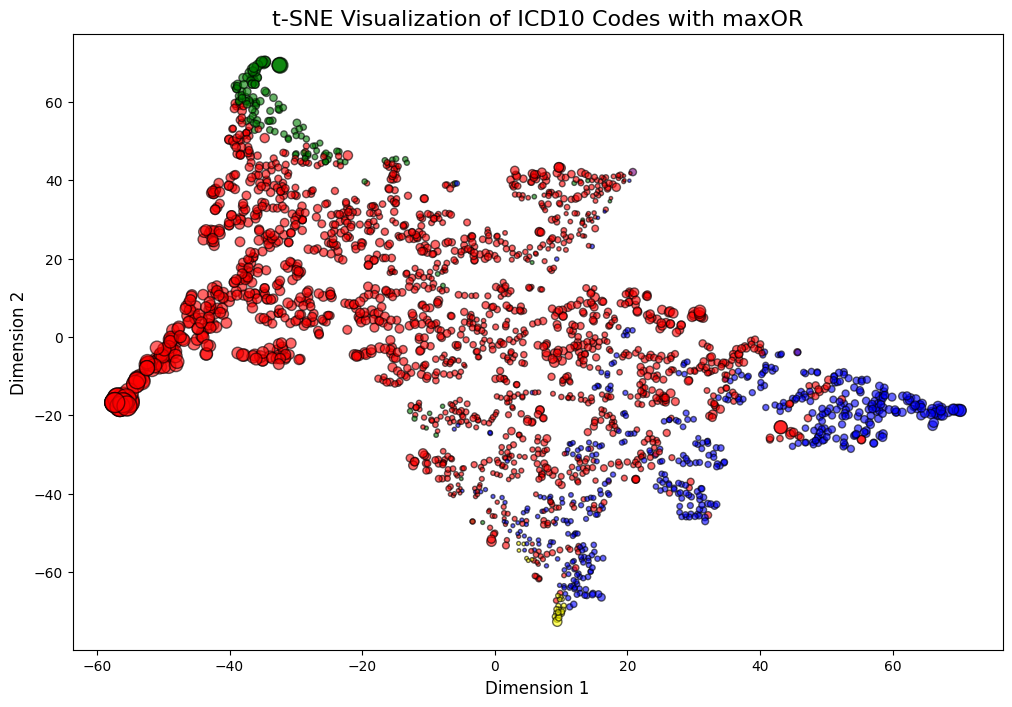

In [246]:
# プロット順序をランダム化
np.random.seed(42)
reordered_indices = np.arange(reduced_data.shape[0])
np.random.shuffle(reordered_indices)

# カラーマッピング
colors = [category_color_mapping.get(icd, '#000000') for icd in umap_df["Specific Cluster"]]


# 対数変換 + 平滑化 + スケーリング
scaled_dot_sizes = (np.log1p(umap_df["maxOR"].values) ** 3.0)  # 対数変換と強調を組み合わせ
scaled_dot_sizes = (scaled_dot_sizes - scaled_dot_sizes.min()) / (scaled_dot_sizes.max() - scaled_dot_sizes.min()) * 200
scaled_dot_sizes += 5  # 最小サイズを確保

# プロット
plt.figure(figsize=(12, 8))
plt.scatter(
    reduced_data[reordered_indices, 0],
    reduced_data[reordered_indices, 1],
    c=np.array(colors)[reordered_indices],  # 各ICD10に対応する色を指定
    s=scaled_dot_sizes[reordered_indices],        # ドットサイズをmaxORに基づいて設定
    alpha=0.6,
    edgecolor='k'  # 境界線を黒に設定
)

# グラフの設定
plt.title("t-SNE Visualization of ICD10 Codes with maxOR", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.show()

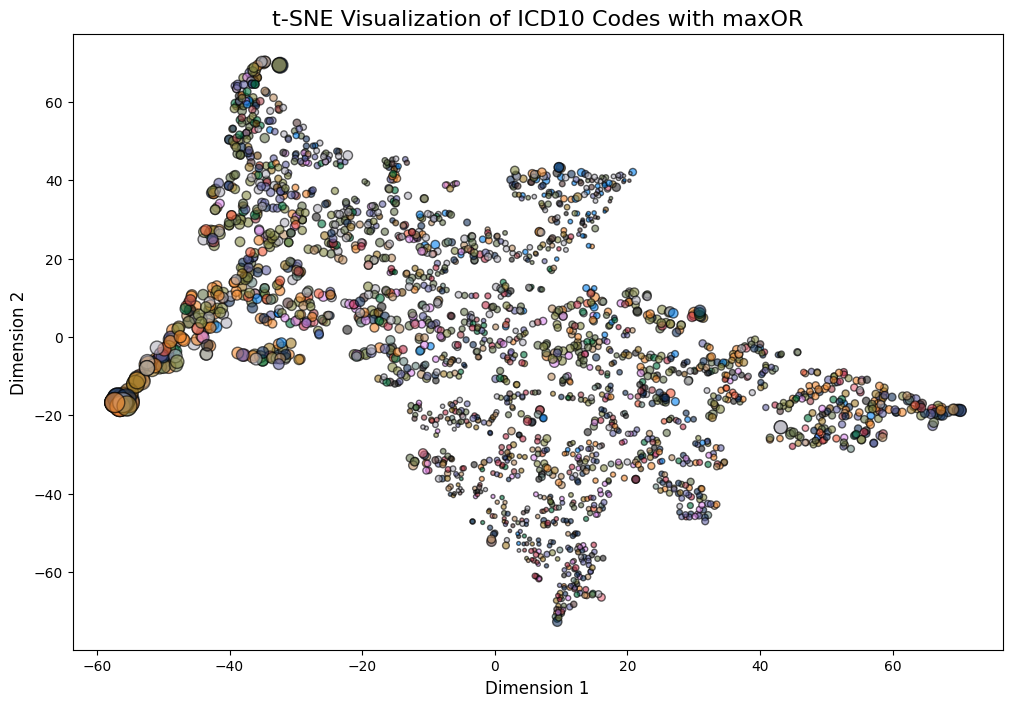

In [53]:
category_color_mapping = {
    'A00–B99': '#a7414a',
    'C00–D48': '#282726',
    'D50–D89': '#6a8a82',
    'E00–E90': '#a37c27',
    'F00–F99': '#563838',
    'G00–G99': '#0584f2',
    'H00–H59': '#f28a30',
    'H60–H95': '#f05837',
    'I00–I99': '#6465a5',
    'J00–J99': '#00743f',
    'K00–K93': '#be9063',
    'L00–L99': '#de8cf0',
    'M00–M99': '#888c46',
    'N00–N99': '#c0334d',
    'O00–O99': '#270101',
    'P00–P96': '#8d2f23',
    'Q00–Q99': '#ee6c81',
    'R00–R99': '#65734b',
    'S00–T98': '#14325c',
    'V01–Y98': '#704307',
    'Z00–Z99': '#b5b3be',
    'U00–U99': '#f67280'
}



# プロット順序をランダム化
np.random.seed(42)
reordered_indices = np.arange(reduced_data.shape[0])
np.random.shuffle(reordered_indices)

# カラーマッピング
colors = [category_color_mapping.get(icd, '#000000') for icd in umap_df["ICD_chape"]]


# 対数変換 + 平滑化 + スケーリング
scaled_dot_sizes = (np.log1p(umap_df["maxOR"].values) ** 3.0)  # 対数変換と強調を組み合わせ
scaled_dot_sizes = (scaled_dot_sizes - scaled_dot_sizes.min()) / (scaled_dot_sizes.max() - scaled_dot_sizes.min()) * 200
scaled_dot_sizes += 5  # 最小サイズを確保

# プロット
plt.figure(figsize=(12, 8))
plt.scatter(
    reduced_data[reordered_indices, 0],
    reduced_data[reordered_indices, 1],
    c=np.array(colors)[reordered_indices],  # 各ICD10に対応する色を指定
    s=scaled_dot_sizes[reordered_indices],        # ドットサイズをmaxORに基づいて設定
    alpha=0.6,
    edgecolor='k'  # 境界線を黒に設定
)

# グラフの設定
plt.title("t-SNE Visualization of ICD10 Codes with maxOR", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.show()

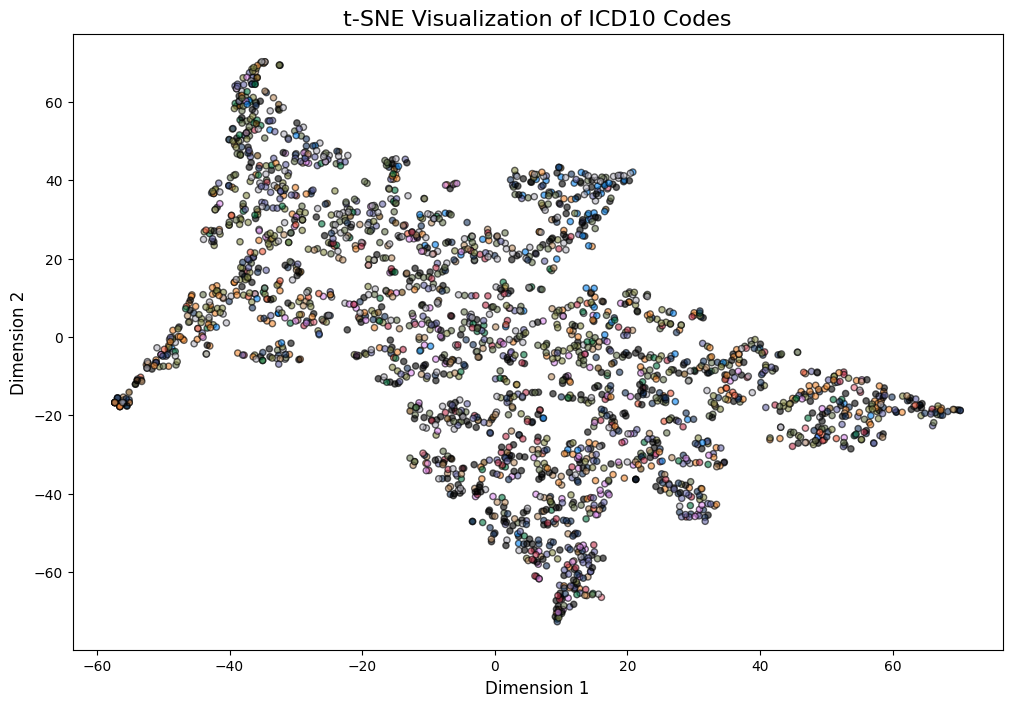

In [200]:
# プロット順序をランダム化
np.random.seed(42)
reordered_indices = np.arange(reduced_data.shape[0])
np.random.shuffle(reordered_indices)

# カラーマッピング
colors = [category_color_mapping.get(icd, '#000000') for icd in umap_df["ICD_chape"]]

# プロット
plt.figure(figsize=(12, 8))
plt.scatter(
    reduced_data[reordered_indices, 0],
    reduced_data[reordered_indices, 1],
    c=np.array(colors)[reordered_indices],  # 各ICD10に対応する色を指定
    s=20,
    alpha=0.6,
    edgecolor='k'  # 境界線を黒に設定
)

# グラフの設定
plt.title("t-SNE Visualization of ICD10 Codes", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.show()


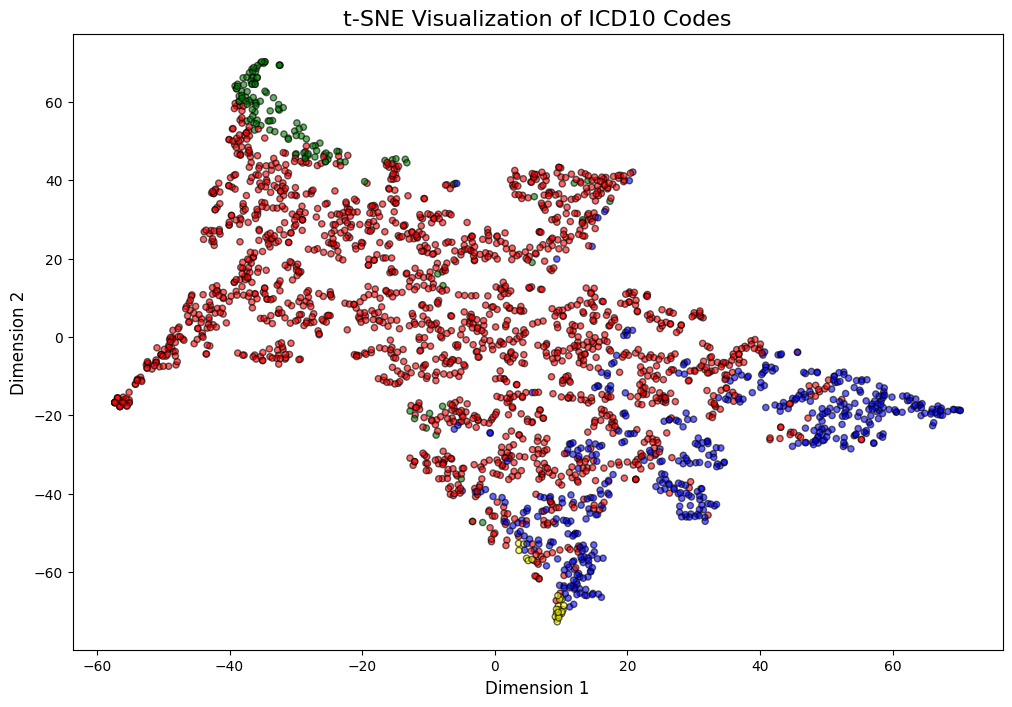

In [201]:
# プロット順序をランダム化
np.random.seed(42)
reordered_indices = np.arange(reduced_data.shape[0])
np.random.shuffle(reordered_indices)

# カラーマッピング
colors = [category_color_mapping.get(icd, '#000000') for icd in umap_df["Specific Cluster"]]

# プロット
plt.figure(figsize=(12, 8))
plt.scatter(
    reduced_data[reordered_indices, 0],
    reduced_data[reordered_indices, 1],
    c=np.array(colors)[reordered_indices],  # 各ICD10に対応する色を指定
    s=20,
    alpha=0.6,
    edgecolor='k'  # 境界線を黒に設定
)

# グラフの設定
plt.title("t-SNE Visualization of ICD10 Codes", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


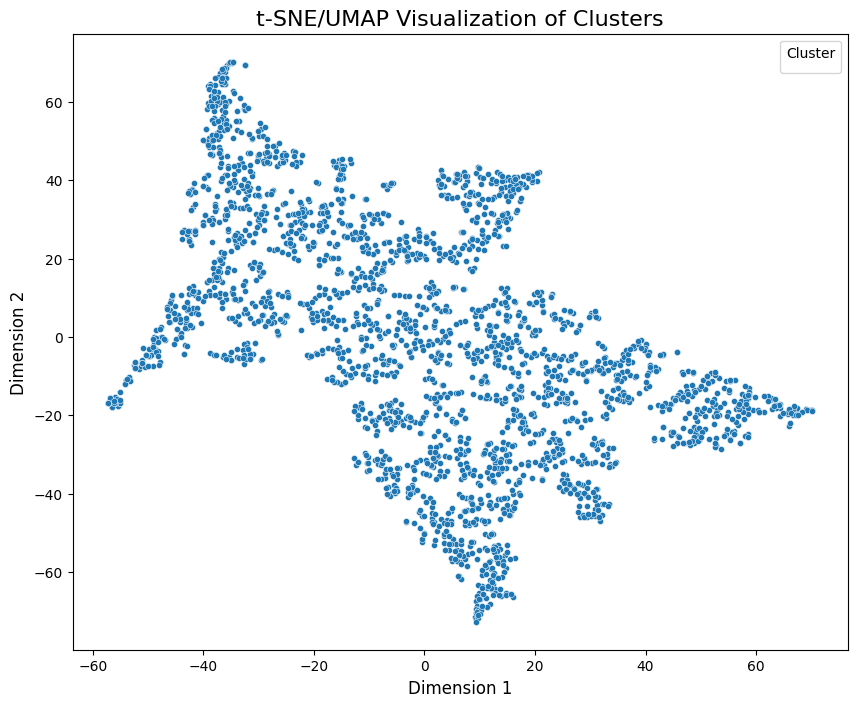

In [133]:
# クラスターごとの色付け
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced_data[:, 0],
    y=reduced_data[:, 1],
    #hue=cluster_labels,  # クラスターID（例: 0, 1, 2,...）
    palette='tab10',    # 任意のカラーパレット
    s=20               # 点のサイズ
)
plt.title("t-SNE/UMAP Visualization of Clusters", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.legend(title="Cluster", fontsize=10)
plt.show()